In [1]:
!nvidia-smi

Mon Oct 19 20:41:54 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 455.23.05    Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   45C    P8    11W /  70W |      0MiB / 15079MiB |      0%      Default |
|                               |                      |                 ERR! |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [2]:
!pip install transformers

     |████████████████████████████████| 1.1MB 4.5MB/s 
     |████████████████████████████████| 3.0MB 24.2MB/s 
     |████████████████████████████████| 890kB 51.7MB/s 
     |████████████████████████████████| 1.1MB 44.9MB/s 
  Created wheel for sacremoses: filename=sacremoses-0.0.43-cp36-none-any.whl size=893257 sha256=b35c1ae65f08e8f72cd8286c7c227cb6ae9c3b7e57ea2964a3e34d3f529670be
  Stored in directory: /root/.cache/pip/wheels/29/3c/fd/7ce5c3f0666dab31a50123635e6fb5e19ceb42ce38d4e58f45
Successfully built sacremoses


In [3]:
!pip install indic-transliteration

     |████████████████████████████████| 102kB 5.2MB/s 
     |████████████████████████████████| 665kB 20.6MB/s 
     |████████████████████████████████| 911kB 34.7MB/s 
  Found existing installation: regex 2019.12.20
    Uninstalling regex-2019.12.20:
      Successfully uninstalled regex-2019.12.20


In [4]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [5]:
#importing all necessary libraries
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
from torch.optim.lr_scheduler import MultiStepLR

from sklearn.preprocessing import LabelEncoder
from itertools import chain # for flatting the list
from mlxtend.plotting import plot_confusion_matrix
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix


from transformers import BertModel
from transformers import BertTokenizer
from transformers import AutoModel, AutoTokenizer


from indic_transliteration import sanscript
from indic_transliteration.sanscript import SchemeMap, SCHEMES, transliterate

import re
import unicodedata
import codecs
import random

In [6]:
# for reproducibility
torch.manual_seed(0)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False
np.random.seed(0)

In [7]:
random.random()

0.869196311390526

In [8]:
#dataset classs for ATIS data
class ATIS(Dataset):

  def __init__(self, file_name, translit_prob=0, shuffle_prob=0, max_token_len=100):
    super(ATIS, self).__init__()

    self.df = pd.read_csv(file_name, header=None, sep = '\t')
    self.tokenizer = BertTokenizer.from_pretrained('bert-base-multilingual-cased')
    self.max_token_len = max_token_len
    self.translit_prob = translit_prob
    self.shuffle_prob = shuffle_prob
    
    self.label_encoder = LabelEncoder().fit(list(self.df[0]))


  def __len__(self):
    return len(self.df)

  def __getitem__(self, index):

    query = self.df.iloc[index, 1]
    query = self.query_preprocessing(query)

    if random.random() < self.shuffle_prob:
      query_list = query.split()
      if len(query_list) < 10:
        random.shuffle(query_list)
        query = " ".join(query_list)


    
    label = self.label_encoder.transform([self.df.iloc[index, 0]])
    
    # print(query)
    # print(label)
    
    tokens = self.tokenizer.tokenize(query)
    tokens = ['[CLS]'] + tokens + ['[SEP]']

    if len(tokens) < self.max_token_len:
      tokens = tokens + ['[PAD]' for i in range(self.max_token_len-len(tokens))]
    else:
      tokens = tokens[:self.max_token_len-1] + ['[SEP]']
    
    token_ids = self.tokenizer.convert_tokens_to_ids(tokens)
    
    token_id_tensor = torch.tensor(token_ids)
    label_tensor = torch.tensor(label)
    attention_mask_tensor = (token_id_tensor != 0).long()

    return token_id_tensor, attention_mask_tensor, label_tensor

  def unicodeToAscii(self, s):
    return ''.join(c for c in unicodedata.normalize('NFD', s) if unicodedata.category(c) != 'Mn')

  def normalizeString(self, s):
    s = self.unicodeToAscii(s.lower().strip())
    s = re.sub(r"([.!?])", r"", s)
    s = re.sub(r"\s+", r" ", s).strip()
    return s
  
  
  def query_preprocessing(self, query_text):
    q= self.normalizeString(query_text)

    if random.random() < self.translit_prob:                      ## translit according to translit probability
      q = transliterate(q, sanscript.HK, sanscript.MALAYALAM)
    return q

In [9]:
train_file = '/content/drive/My Drive/Summer_2020/HASOC/Task1/data/ml-Hasoc-offensive-train.csv'
test_file = '/content/drive/My Drive/Summer_2020/HASOC/Task1/data/ml-Hasoc-offensive-dev.csv'

In [10]:
# creating instance of datset class
train_set = ATIS(file_name = train_file, max_token_len=120, translit_prob=0.5, shuffle_prob=0)
test_set = ATIS(file_name = test_file, max_token_len=120, translit_prob=0, shuffle_prob=0)

In [11]:
print(len(train_set))
print(len(test_set))

3200
400


In [12]:
train_set[3]

(tensor([   101,   1329,  30708,   1361,  27921, 111380,  34590,   1321,   1359,
         111388,  18384, 111377,  59956, 111369, 111369, 111369, 111369,   1353,
          24164,  82624,  43260, 108628,  43877, 111383,  24164,   1348,  24164,
          23290,  59009,  38847,  27921,  99733,    102,      0,      0,      0,
              0,      0,      0,      0,      0,      0,      0,      0,      0,
              0,      0,      0,      0,      0,      0,      0,      0,      0,
              0,      0,      0,      0,      0,      0,      0,      0,      0,
              0,      0,      0,      0,      0,      0,      0,      0,      0,
              0,      0,      0,      0,      0,      0,      0,      0,      0,
              0,      0,      0,      0,      0,      0,      0,      0,      0,
              0,      0,      0,      0,      0,      0,      0,      0,      0,
              0,      0,      0,      0,      0,      0,      0,      0,      0,
              0,      0,    

In [13]:
train_loader = DataLoader(train_set, batch_size = 64, num_workers = 4, shuffle=True)
val_loader = DataLoader(test_set, batch_size = 64, num_workers =4, shuffle=False)

In [14]:
for i, data in enumerate(train_loader, 0):
  print(data[0].shape)
  print(data[1].shape)
  print(data[2].shape)
  break

torch.Size([64, 120])
torch.Size([64, 120])
torch.Size([64, 1])


In [16]:
class INTENT_CLASSIFIER(nn.Module):
  
  def __init__(self, freeze_bert=True):
    super(INTENT_CLASSIFIER, self).__init__()

    self.bert_layers = BertModel.from_pretrained('bert-base-multilingual-cased')
    self.linear1 = nn.Linear(768, 300)
    self.linear11 = nn.Linear(300, 8)
    self.linear2 = nn.Linear(8, 2)
    self.dropout = nn.Dropout(0.5)

    if freeze_bert:
      for param in self.bert_layers.parameters():
        param.requires_grad = False


  def forward(self, token_ids, atten_mask):
    """Both argument are of shape: batch_size, max_seq_len"""
    _, CLS = self.bert_layers(token_ids, attention_mask = atten_mask)
    logits = self.dropout(self.linear1(CLS))
    logits = self.dropout(self.linear11(logits))
    logits = self.linear2(logits)

    return logits

In [17]:
model = INTENT_CLASSIFIER(freeze_bert=True)

In [18]:
# len(model.bert_layers.encoder)

In [19]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(device)

cuda


In [ ]:
class_weights = torch.tensor([1.0, 5.0]).to(device)    ## for weighted cross entropy  

In [ ]:
# optimizer and loss function
criterion = nn.CrossEntropyLoss() #weight=class_weights
optimizer = torch.optim.Adam(model.parameters(), lr=1E-5, weight_decay =0.0001)
scheduler = MultiStepLR(optimizer, milestones=[26, 65, 75, 85, 95, 105, 115], gamma=0.8)

In [ ]:
model.to(device)
print(f"model loaded to {device}")

model loaded to cuda


In [ ]:
# Getting the train accuracy
def train_acc():
  correct = 0
  total = 0
  model.eval()
  y_train_prediction = []
  y_train_true = []
  with torch.no_grad():
      for data in train_loader:
          tokens, masks, labels = data
          
          tokens = tokens.to(device)
          masks = masks.to(device)
          labels = labels.to(device)

          outputs = model(tokens, masks)
          _, predicted = torch.max(outputs.data, 1)
          total += labels.size(0)
          correct += (predicted == labels.squeeze()).sum().item()

          y_train_true += labels.squeeze().detach().cpu().numpy().tolist()
          y_train_prediction += predicted.detach().cpu().numpy().tolist()

  print('Train Accuracy: {}%'.format(100*correct/total))
  return y_train_true, y_train_prediction

In [ ]:
# Getting the test accuracy
def test():
  correct = 0
  total = 0
  model.eval()
  y_test_prediction = []
  y_test_true = []

  with torch.no_grad():
      for data in val_loader:
          tokens, masks, labels = data
          
          tokens = tokens.to(device)
          masks = masks.to(device)
          labels = labels.to(device)

          outputs = model(tokens, masks)
          _, predicted = torch.max(outputs.data, 1)
          total += labels.size(0)
          correct += (predicted == labels.squeeze()).sum().item()

          y_test_true += labels.squeeze().detach().cpu().numpy().tolist()
          y_test_prediction += predicted.detach().cpu().numpy().tolist()

  print('Test Accuracy: {}%'.format(100 * correct / total))
  test_accuracy_value = correct/total
  return y_test_true, y_test_prediction, test_accuracy_value

In [ ]:
for param in model.bert_layers.parameters():
  param.requires_grad = False

In [ ]:
# training funciton
def train(epochs):
  best_accuracy = 0.0
  loss_list= []
  for epoch in range(1, epochs+1):  # loop over the dataset multiple times

      running_loss = 0.0
      for i, data in enumerate(train_loader, 0):
          # get the inputs; data is a list of [inputs, masks, labels]
          inputs, masks,  labels = data

          inputs = inputs.to(device)
          masks = masks.to(device)
          labels = labels.to(device)

          # zero the parameter gradients
          optimizer.zero_grad()

          # forward + backward + optimize
          outputs = model(inputs, masks)
          loss = criterion(outputs, labels.squeeze())
          loss.backward()
          optimizer.step()

          # print statistics
          running_loss += loss.item()
          if i % 5 == 4:    # print every 2000 mini-batches
              print('[%d, %5d] loss: %.3f' %
                    (epoch, i + 1, running_loss / 5))
              loss_list.append(running_loss/5)
              running_loss = 0.0
          
      if (epoch == 5): # gradual unfreezing of Bert pameters
        print("Unfrezing layer number {}+++++++++++++++++++++++++++")
        # making last layers unfreeze
        for param in model.bert_layers.parameters():
          param.requires_grad = True

      _,_, test_accuracy_value = test()

      if test_accuracy_value > best_accuracy:
        torch.save(model, './best_model.pth')
        best_accuracy = test_accuracy_value
        print("Model Improved..... New model saved...")
      else:
        print("No improvement on previous model...")

      _ = train_acc()
      scheduler.step()    

  print('Finished Training')
  return loss_list

In [ ]:
loss_list = train(epochs=120)

[1,     5] loss: 0.675
[1,    10] loss: 0.669
[1,    15] loss: 0.664
[1,    20] loss: 0.668
[1,    25] loss: 0.664
[1,    30] loss: 0.659
[1,    35] loss: 0.658
[1,    40] loss: 0.651
[1,    45] loss: 0.652
[1,    50] loss: 0.644
Test Accuracy: 82.0%
Model Improved..... New model saved...
Train Accuracy: 82.28125%
[2,     5] loss: 0.642
[2,    10] loss: 0.640
[2,    15] loss: 0.636
[2,    20] loss: 0.636
[2,    25] loss: 0.636
[2,    30] loss: 0.636
[2,    35] loss: 0.624
[2,    40] loss: 0.616
[2,    45] loss: 0.623
[2,    50] loss: 0.612
Test Accuracy: 82.0%
No improvement on previous model...
Train Accuracy: 82.28125%
[3,     5] loss: 0.609
[3,    10] loss: 0.617
[3,    15] loss: 0.611
[3,    20] loss: 0.605
[3,    25] loss: 0.604
[3,    30] loss: 0.596
[3,    35] loss: 0.603
[3,    40] loss: 0.597
[3,    45] loss: 0.596
[3,    50] loss: 0.575
Test Accuracy: 82.0%
No improvement on previous model...
Train Accuracy: 82.28125%
[4,     5] loss: 0.583
[4,    10] loss: 0.584
[4,    15] l

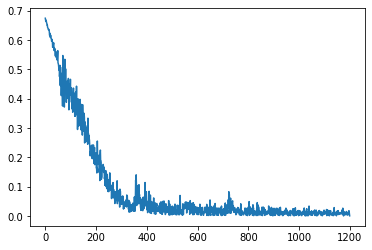

In [ ]:
plt.plot(loss_list)

In [ ]:
#loading the model
model = torch.load('./best_model.pth')

In [ ]:
y_test_true, y_test_prediction, _ = test()
y_train_true, y_train_prediction= train_acc()

Test Accuracy: 92.5%
Train Accuracy: 99.3125%


In [ ]:
test_set.label_encoder.inverse_transform([0, 1])

array(['Not_offensive ', 'Offensive'], dtype='<U14')

In [ ]:
from mlxtend.plotting import plot_confusion_matrix
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import accuracy_score, cohen_kappa_score, confusion_matrix, classification_report

In [ ]:
target_names = ['Not_offensive ', 'Offensive']

In [ ]:
print("Test Accuracy", accuracy_score(y_test_true, y_test_prediction))
print("Train Accuracy", accuracy_score(y_train_true, y_train_prediction))
print("Test Kappa Score", cohen_kappa_score(y_test_true, y_test_prediction))
print("Train Kappa Score", cohen_kappa_score(y_train_true, y_train_prediction))

Test Accuracy 0.915
Train Accuracy 0.9965625
Test Kappa Score 0.6730769230769231
Train Kappa Score 0.9883000038556805


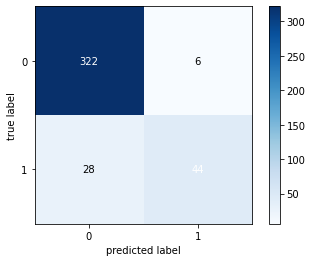

In [ ]:
multiclass = confusion_matrix(y_test_true, y_test_prediction)

class_names = target_names

fig, ax = plot_confusion_matrix(conf_mat=multiclass,
                                colorbar=True,
                                show_absolute=True,
                                show_normed=False)
plt.show()

In [ ]:
#without transliteration data augmentation
print(classification_report(y_test_true, y_test_prediction))

              precision    recall  f1-score   support

           0       0.92      0.98      0.95       328
           1       0.88      0.61      0.72        72

    accuracy                           0.92       400
   macro avg       0.90      0.80      0.84       400
weighted avg       0.91      0.92      0.91       400



In [ ]:
# with tranliteration data augmentation
print(classification_report(y_test_true, y_test_prediction))

              precision    recall  f1-score   support

           0       0.96      0.98      0.97       328
           1       0.91      0.81      0.85        72

    accuracy                           0.95       400
   macro avg       0.93      0.89      0.91       400
weighted avg       0.95      0.95      0.95       400



# **First need to have dataset class to read test data**

In [ ]:
test_set.label_encoder.inverse_transform([0, 1])

array(['Not_offensive ', 'Offensive'], dtype='<U14')

In [ ]:
#dataset classs for ATIS data
class ATIS(Dataset):

  def __init__(self, file_name, translit_prob=0, shuffle_prob=0, max_token_len=100):
    super(ATIS, self).__init__()

    self.df = pd.read_csv(file_name, header=None) ##################################3
    self.tokenizer = BertTokenizer.from_pretrained('bert-base-multilingual-cased')
    self.max_token_len = max_token_len
    self.translit_prob = translit_prob
    self.shuffle_prob = shuffle_prob
    
    # self.label_encoder = LabelEncoder().fit(list(self.df[0]))


  def __len__(self):
    return len(self.df)

  def __getitem__(self, index):

    query_original = self.df.iloc[index, 1]
    query = self.query_preprocessing(query_original)
    query_id = self.df.iloc[index, 0]

    tokens = self.tokenizer.tokenize(query)
    tokens = ['[CLS]'] + tokens + ['[SEP]']

    if len(tokens) < self.max_token_len:
      tokens = tokens + ['[PAD]' for i in range(self.max_token_len-len(tokens))]
    else:
      tokens = tokens[:self.max_token_len-1] + ['[SEP]']
    
    token_ids = self.tokenizer.convert_tokens_to_ids(tokens)
    
    token_id_tensor = torch.tensor(token_ids)
    # label_tensor = torch.tensor(label)
    attention_mask_tensor = (token_id_tensor != 0).long()

    return token_id_tensor, attention_mask_tensor, query_original, query_id

  def unicodeToAscii(self, s):
    return ''.join(c for c in unicodedata.normalize('NFD', s) if unicodedata.category(c) != 'Mn')

  def normalizeString(self, s):
    s = self.unicodeToAscii(s.lower().strip())
    s = re.sub(r"([.!?])", r"", s)
    s = re.sub(r"\s+", r" ", s).strip()
    return s
  
  
  def query_preprocessing(self, query_text):
    q= self.normalizeString(query_text)

    # if random.random() < self.translit_prob:                      ## translit according to translit probability
    # q = transliterate(q, sanscript.HK, sanscript.MALAYALAM)
    return q

In [ ]:
test_test_file = '/content/drive/My Drive/Summer_2020/HASOC/Task1/data/ml_task_1_test_test.csv'

In [ ]:
test_test_set = ATIS(file_name = test_test_file, max_token_len=120, translit_prob=0, shuffle_prob=0)

In [ ]:
test_test_set[9]

(tensor([   101,   1353,  20854,  20854,  15292,   1353,  35019,    123,  23607,
          49249,   1322, 111393,  18395,  20854,  58167,   1355,  29400,  25406,
         111397,   1323,  17896,  17896,   1323, 111385, 111385,  23948,  42870,
          17896,  17896,  36877,  24458,    100,   1328, 111388, 111388,  24458,
          22945,   1348,  60434,  42870,  53144,    102,      0,      0,      0,
              0,      0,      0,      0,      0,      0,      0,      0,      0,
              0,      0,      0,      0,      0,      0,      0,      0,      0,
              0,      0,      0,      0,      0,      0,      0,      0,      0,
              0,      0,      0,      0,      0,      0,      0,      0,      0,
              0,      0,      0,      0,      0,      0,      0,      0,      0,
              0,      0,      0,      0,      0,      0,      0,      0,      0,
              0,      0,      0,      0,      0,      0,      0,      0,      0,
              0,      0,    

In [ ]:
test_loader = DataLoader(test_test_set, batch_size = 1, num_workers =4, shuffle=False)

In [ ]:
for i, da in enumerate(test_loader, 0):
  print(data[0].shape)
  print(data[1].shape)
  print(data[2])
  print(data[3])
  break

torch.Size([1, 120])
torch.Size([1, 120])
('Theatoril climax maathram kaanichal mathiyallo eny... any ways good trailor',)
('ml_1',)


In [ ]:
count = 0
for data in test_loader:
  tokens, masks, query, query_id = data
  print(tokens)
  print(masks)
  print(query[0])
  print(query_id[0])
  count +=1
  if count == 1:
    break

tensor([[  101, 10105, 45804, 10161, 21700, 10686, 49123, 11143, 13845, 10730,
         57052, 18453, 82116, 14990, 13660, 10110, 10157, 11178, 30360, 15198,
         56559, 10667,   102,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0]])
tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,

In [ ]:
# path where model is saved and loaded
model_path = '/content/drive/My Drive/Summer_2020/HASOC/Task1/model/task1_G.pth'

In [ ]:
#loading the model
model = torch.load(model_path)

In [ ]:
_ = test()

Test Accuracy: 95.0%


In [ ]:
# Getting the test accuracy
def inference():
  model.eval()
 
  query_id_list = []
  query_list = []
  prediction_list = []
  running_sum = 0

  with torch.no_grad():
      for data in test_loader:
          tokens, masks, query, query_id = data
          
          query_id_list.append(query_id[0])
          query_list.append(query[0])
          
          tokens = tokens.to(device)
          masks = masks.to(device)

          outputs = model(tokens, masks)
          _, predicted = torch.max(outputs.data, 1)
          running_sum+=predicted.detach().cpu().item()

          prediction_list.append('off' if predicted==1 else 'not')
          # break

          # y_test_true += labels.squeeze().detach().cpu().numpy().tolist()
          # y_test_prediction += predicted.detach().cpu().numpy().tolist()

  # print('Test Accuracy: {}%'.format(100 * correct / total))
  # test_accuracy_value = correct/total
  return running_sum, query_id_list, query_list, prediction_list

In [ ]:
rsum, qid, q, p = inference()

In [ ]:
rsum

62

In [ ]:
print(len(q))
print(len(p))
print(len(qid))

400
400
400


In [ ]:
inf_df = pd.DataFrame()

In [ ]:
inf_df['id'] = qid
inf_df['text'] = q
inf_df['label'] = p

In [ ]:
inf_df

,id,text,label
0,ml_1,Theatoril climax maathram kaanichal mathiyallo...,not
1,ml_2,Shah Rukh Khan inte FAN cinema de cheriya samy...,not
2,ml_3,Heavy Stills onnum oru rekshem illa adipoli fd...,not
3,ml_4,Eee trailer njan ethra pravishyam nokiyann eni...,not
4,ml_5,Ikka ethu engane sathikunu enna oru mass I lov...,not
...,...,...,...
395,ml_396,മരണ മാസ് വെയ്റ്റിംഗ് ഷൈൻ നിഗം ഇസ്തം,not
396,ml_397,Trailer kandappol oru kaaryam urappichu... Kaa...,not
397,ml_398,Ee Padam hitakkamo ennnariyilla Pakshe ee On...,not
398,ml_399,Lalettan kidu maazz .... .... Super.......,not


In [ ]:
#Teamname_task1ortask2_language_submissionnumber.tsv

In [ ]:
inf_df.to_csv('./CFILT_IITBombay_task1_malayalam_submission_1.tsv', index=None, sep='\t')

In [ ]:
pd.read_csv('./CFILT_IITBombay_task1_malayalam_submission_1.tsv',sep='\t')

,id,text,label
0,ml_1,Theatoril climax maathram kaanichal mathiyallo...,not
1,ml_2,Shah Rukh Khan inte FAN cinema de cheriya samy...,not
2,ml_3,Heavy Stills onnum oru rekshem illa adipoli fd...,not
3,ml_4,Eee trailer njan ethra pravishyam nokiyann eni...,not
4,ml_5,Ikka ethu engane sathikunu enna oru mass I lov...,not
...,...,...,...
395,ml_396,മരണ മാസ് വെയ്റ്റിംഗ് ഷൈൻ നിഗം ഇസ്തം,not
396,ml_397,Trailer kandappol oru kaaryam urappichu... Kaa...,not
397,ml_398,Ee Padam hitakkamo ennnariyilla Pakshe ee On...,not
398,ml_399,Lalettan kidu maazz .... .... Super.......,not
